### This jupyter notebooks provides the code for classifying signals using the Continuous Wavelet Transform and Convolutional Neural Networks.
### To get some more background information, please have a look at the accompanying blog-post:
### http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

# 1. Loading the UCI HAR dataset into an numpy ndarray
Download dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [9]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.strip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../datasets/UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(train_signals, (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(test_signals, (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


# 2. Applying a CWT to UCI HAR signals and saving the resulting scaleogram into an numpy ndarray

In [3]:
scales = range(1,128)
waveletname = 'morl'
train_size = 1000
train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9))

for ii in range(0,train_size):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

test_size = 100
test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_test[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        #coeff_ = coeff
        test_data_cwt[ii, :, :, jj] = coeff_

0
0


# 3. Training a Convolutional Neural Network

In [4]:
x_train = train_data_cwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(uci_har_labels_test[:test_size])
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

batch_size = 16
epochs = 2

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

# convert the data to the right type
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1000, 127, 127, 9)
1000 train samples
100 test samples


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/2
63/63 [==============================] - 36s 577ms/step - loss: 1.1853 - accuracy: 0.6660 - val_loss: 0.4933 - val_accuracy: 0.8500
Epoch 2/2
63/63 [==============================] - 34s 547ms/step - loss: 0.3000 - accuracy: 0.9070 - val_loss: 0.3713 - val_accuracy: 0.8500
Train loss: 0.1690875142812729, Train accuracy: 0.9330000281333923
Test loss: 0.3713051974773407, Test accuracy: 0.8500000238418579


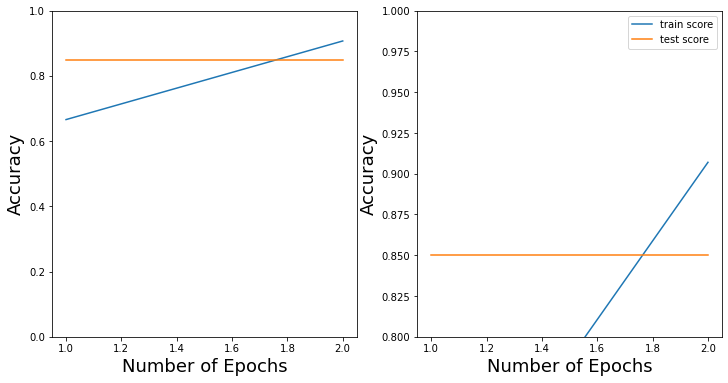

In [6]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, epochs+1), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, epochs+1), history.history['val_accuracy'], label='test score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, epochs+1), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, epochs+1), history.history['val_accuracy'], label='test score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
axarr[1].set_ylim([0.8,1])
plt.legend()
plt.show()

In [7]:
wavlist = pywt.wavelist(kind='continuous')
wavlist

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [8]:
pip list | grep tensorflow

tensorflow                         2.3.1
tensorflow-estimator               2.3.0
Note: you may need to restart the kernel to use updated packages.
